# Graph Network-based Simulator (GNS)

Gonzalez et al. first introduced the concept and architecture of the GNS in 2020 in their now classic [paper](https://proceedings.mlr.press/v119/sanchez-gonzalez20a.html). Since then, several fields have implemented the architecture for particle simulations due to certain favorable inductive biases of the architecture and implementation. We explore the question if the GNS architecture is also useful for FEM based simulations in the *inverse* problem with *output-only* data. Determining the parameters of a physical system with output-only measurements of a proxy of the true state is still an open problem. To begin this feasibility study, we start with a toy example, starting with a static loading problem and a simple Euler-Bernoulli cantilever beam. We also build the necessary code to solve more complicated problems in the future

## Installing packages

In [1]:
import os
import torch
import math
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [2]:
# Installation of depedencies

!pip install torch_geometric

# Optional dependencies:
#
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 16.3 MB/s eta 0:00:00


In [3]:
# Import of libraries
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops
import torch_cluster
import torch_scatter
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

PyTorch has version 2.3.1+cu121 with cuda 12.1


## Building the GNS

The rough workflow is as follows:

$$ x \rightarrow G \rightarrow Encoder \rightarrow Processor \rightarrow Decoder \rightarrow y$$

First, create a function to generate a graph from raw data.

In the following function, we create a graphic representation of the physical data, by using the coordinates and the displacement from FEM analysis

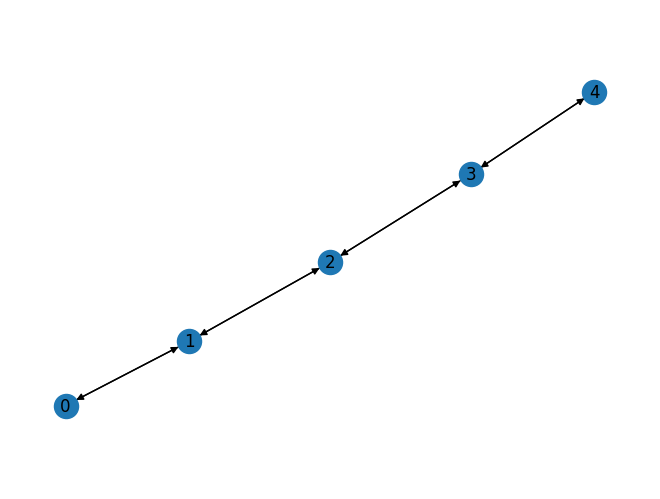

tensor([[ 1.0000, -1.0000,  0.0000,  0.2381],
        [ 1.0000,  1.0000,  0.0000,  9.3448],
        [ 1.0000, -1.0000,  0.0000,  8.2983],
        [ 1.0000,  1.0000,  0.0000,  3.6964],
        [ 1.0000, -1.0000,  0.0000,  5.6253],
        [ 1.0000,  1.0000,  0.0000,  1.2209],
        [ 1.0000, -1.0000,  0.0000,  1.3027],
        [ 1.0000,  1.0000,  0.0000,  2.6589]])


In [4]:
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.utils import to_networkx
import networkx as nx

def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    node_features = torch.tensor(coordinates, dtype=torch.float)

    # Add the load as a node attribute
    load = torch.rand(node_features.size(0), 1) * metadata["P_initial"]
    dist_boundary = torch.norm(node_features - torch.tensor([[0, 0]], dtype=torch.float), dim=1).unsqueeze(1)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(node_features, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(node_features[edge_index[0]] - node_features[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (node_features[edge_index[1]] - node_features[edge_index[0]])

    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Create a graph data object
    graph_data = Data(pos=node_features, edge_index=edge_index, edge_attr=edge_attr, node_attr=load)

    return graph_data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.edge_attr)

We can then code up a simple MLP helper class to use in our architecture.

In [5]:
class MLP(nn.Module):
    """
    Create a simple MLP class for future help in the creation of the GNN network.
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            if (i < len(sizes) - 2):
                act = activation
            else:
                act = output_activation
            layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Encoder and Decoder

We then can create our encoder and decoder classes.

In [1]:
class Encoder(nn.Module):
    """ Encoder class for the GNN model. 
    
    The encoder is responsible for processing the input data (node and edge features) and
    transforming it into a form that can be used by the processor block.

    Args:
    - node_in (int): The number of input features for each node.
    - node_out (int): The number of output features for each node.
    - edge_in (int): The number of input features for each edge.
    - edge_out (int): The number of output features for each edge.
    - mlp_num_layers (int): The number of layers in the MLP.
    - mlp_hidden_dim (int): The number of hidden units in each layer of the MLP.

    Attributes:
    - node_fn (nn.Module): The node feature transformation function.
    - edge_fn (nn.Module): The edge feature transformation function.

    Returns:
    - node_out (int): The number of output features for each node.
    - edge_out (int): The number of output features for each edge.
    
    """
    def __init__(
        self,
        node_in, # same shape as the data vertices (nodes) WARNING
        node_out, # shape for the processor block
        edge_in, # same shape as the data edges (elements)
        edge_out, # shape for the processor block
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Encoder, self).__init__()

        ############################################################################
        # TODO: Implement the encoder.
        # Hint: The node_fn and edge_fn are of the same structure, which is a MLP layer followed by a layer norm
        ############################################################################
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out),
            nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out),
            nn.LayerNorm(edge_out)])
        ############################################################################

    def forward(self, x, e_features): # global_features
        '''
        x: (E, node_in)
        edge_index: (2, E)
        e_features: (E, edge_in)
        '''
        return self.node_fn(x), self.edge_fn(e_features)

class Decoder(nn.Module):
    def __init__(
        self,
        node_in, # directly from the processor
        node_out, # this shape needs to be (num_nodes of real problem x 2). The first column should be u, the second should be p.
        edge_in, # directly from the processor
        edge_out, # this shape needs to be (num_elements of real problem x 1). The first column should be ei.
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Decoder, self).__init__()
        ############################################################################
        # Implement the decoder.
        # The decoder outputs both node and edge information.
        ############################################################################
        self.node_fn = MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)
        self.edge_fn = MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out)
        ############################################################################

    def forward(self, x, e_features):
        '''
        x: (E, node_in)
        e_features: (E, edge_in)
        '''
        ############################################################################
        # Implement the forward pass.
        ############################################################################
        return self.node_fn(x), self.edge_fn(e_features)
        ############################################################################



NameError: name 'nn' is not defined

### Message passing

We now can create the message passing to be used in the Processor.

In [2]:
class InteractionNetwork(MessagePassing):
    """ Interaction Network class for the GNN model.

    The Interaction Network is a message-passing neural network that can be used to model
    interactions between nodes in a graph. It is based on the MessagePassing class from PyTorch
    Geometric.

    Args:
    - node_fn (nn.Module): The node feature transformation function.
    - edge_fn (nn.Module): The edge feature transformation function.

    Attributes:
    - node_fn (nn.Module): The node feature transformation function.
    - edge_fn (nn.Module): The edge feature transformation function.

    Returns:
    - x_updated (torch.Tensor): The updated node features.
    - e_updated (torch.Tensor): The updated edge features.

    """
    def __init__(
        self,
        node_fn,
        edge_fn,
    ):
        super().__init__()
        self.node_fn = node_fn
        self.edge_fn = edge_fn

    def forward(self, x, edge_index, e_features):
        x_updated, e_updated = self.propagate(edge_index=edge_index, x=x, e_features=e_features)
        return x_updated, e_updated

    def message(self, edge_index, x_i, x_j, e_features):
        message = torch.cat([x_i, x_j, e_features], dim=-1)
        message = self.edge_fn(message)
        return message

    def aggregate(self, messages, index, dim_size=None):
        out = torch_scatter.scatter(messages, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (messages, out)

    def update(self, aggr_out, x, e_features):
        message, aggr = aggr_out
        x_updated = torch.cat([aggr, x], dim=-1)
        x_updated = self.node_fn(x_updated)
        return x_updated+x, e_features+message

NameError: name 'MessagePassing' is not defined

### Processor

The processer has $M$ layers of InteractionNetworks

In [8]:
class Processor(MessagePassing):

    """ Processor class for the GNN model.

    The Processor is a message-passing neural network that can be used to process node and edge
    features in a graph. It is based on the MessagePassing class from PyTorch Geometric.

    Args:
    - node_in (int): The number of input features for each node.
    - node_out (int): The number of output features for each node.
    - edge_in (int): The number of input features for each edge.
    - edge_out (int): The number of output features for each edge.

    Attributes:
    - gnn_stacks (nn.ModuleList): A list of InteractionNetwork layers.

    Returns:
    - x (torch.Tensor): The updated node features.
    - e_features (torch.Tensor): The updated edge features.

    """
    
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Processor, self).__init__(aggr='max')
        self.gnn_stacks = nn.ModuleList([
            InteractionNetwork(
                node_fn = nn.Sequential(*[MLP(node_in+edge_out, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out),
                nn.LayerNorm(node_out)]),
                edge_fn = nn.Sequential(*[MLP(node_in+node_in+edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out),
                nn.LayerNorm(edge_out)])
            ) for _ in range(num_message_passing_steps)])

    def forward(self, x, edge_index, e_features):
        for gnn in self.gnn_stacks:
            x, e_features = gnn(x, edge_index, e_features)
        return x, e_features

Combining the encoder, processor, and decoder into a single network.

In [9]:
class EncodeProcessDecode(nn.Module):
    """ Encode-Process-Decode class for the GNN model.

    The Encode-Process-Decode model is a graph neural network that consists of three main
    components: an encoder, a processor, and a decoder. The encoder is responsible for processing
    the input data (node and edge features) and transforming it into a form that can be used by the
    processor block. The processor block is a message-passing neural network that can be used to
    process node and edge features in a graph. The decoder is responsible for decoding the processed
    data and generating the final output.

    Args:
    - node_in (int): The number of input features for each node.
    - node_out (int): The number of output features for each node.
    - edge_in (int): The number of input features for each edge.
    - edge_out (int): The number of output features for each edge.
    - latent_dim (int): The dimension of the latent space.
    - num_message_passing_steps (int): The number of message passing steps in the processor block.
    - mlp_num_layers (int): The number of layers in the MLP.
    - mlp_hidden_dim (int): The number of hidden units in each layer of the MLP.

    Attributes:
    - encoder (Encoder): The encoder block.
    - processor (Processor): The processor block.
    - decoder (Decoder): The decoder block.

    Returns:
    - node_decoded (torch.Tensor): The decoded node features.
    - edge_decoded (torch.Tensor): The decoded edge features.

    """

    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        latent_dim,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(EncodeProcessDecode, self).__init__()
        
        self._encoder = Encoder(
            node_in=node_in,
            node_out=latent_dim,
            edge_in=edge_in,
            edge_out=latent_dim,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._processor = Processor(
            node_in=latent_dim,
            node_out=latent_dim,
            edge_in=latent_dim,
            edge_out=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._decoder = Decoder(
            node_in=latent_dim,
            node_out=node_out,
            edge_in=latent_dim,
            edge_out=edge_out,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

    def forward(self, x, edge_index, e_features):
        """ Forward pass through the GNN model.

        Args:
        - x (torch.Tensor): The input node features.
        - edge_index (torch.Tensor): The edge index tensor.
        - e_features (torch.Tensor): The input edge features.

        Returns:
        - node_decoded (torch.Tensor): The decoded node features.
        - edge_decoded (torch.Tensor): The decoded edge features.

        """
        x, e_features = self._encoder(x, e_features)
        x, e_features = self._processor(x, edge_index, e_features)
        node_decoded, edge_decoded = self._decoder(x, e_features)
        return node_decoded, edge_decoded



The simulator puts it all together, from raw data to prediction. For the static case, the input is just a single 1-D array of values position values.

In [138]:
class Simulator(nn.Module):
  """ Simulator class for the GNN model.

  The Simulator is a graph neural network that can be used to model the behavior of a physical
  system. It is based on the Encode-Process-Decode model.

  Args:
  - num_nodes (int): The number of nodes in the graph.
  - num_edges (int): The number of edges in the graph.
  - node_dimension (int): The dimension of the node features.
  - edge_dimension (int): The dimension of the edge features.
  - node_in (int): The number of input features for each node.
  - edge_in (int): The number of input features for each edge.
  - latent_dim (int): The dimension of the latent space.
  - num_message_passing_steps (int): The number of message passing steps in the processor block.
  - mlp_num_layers (int): The number of layers in the MLP.
  - mlp_hidden_dim (int): The number of hidden units in each layer of the MLP.
  - connectivity_radius (float): The radius for the connectivity graph.

  Attributes:
  - encode_process_decode (EncodeProcessDecode): The Encode-Process-Decode model.

  Returns:
  - node_decoded (torch.Tensor): The decoded node features.
  - edge_decoded (torch.Tensor): The decoded edge features.

  """
    def __init__(
        self,
        num_nodes,
        num_edges,
        node_dimension,
        edge_dimension,
        node_in,
        edge_in,
        latent_dim, # this is what we choose for the size of the network
        num_message_passing_steps, # this is M
        mlp_num_layers,
        mlp_hidden_dim,
        connectivity_radius,
    ):
        super(Simulator, self).__init__()
        self._connectivity_radius = connectivity_radius

        self._encode_process_decode = EncodeProcessDecode(
            node_in=node_in,
            node_out=node_dimension,
            edge_in=edge_in,
            edge_out=edge_dimension,
            latent_dim=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

    def _create_gnn_graph(self, coordinates):
      pos = coordinates  # Use coordinates directly
      node_features = pos
      edge_index = radius_graph(pos, r=self._connectivity_radius, loop=False)
      distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
      displacement = pos[edge_index[1]] - pos[edge_index[0]]
      edge_attr = torch.cat([distance, displacement], dim=1)
      return node_features, edge_index, edge_attr

    def _decoder_post_processor(self, node_decoded, edge_decoded):
      """ Post-process the decoded node and edge features."""

      # Deflection at each node, (num_nodes x 1), one deflection value in meters for each node
      u = node_decoded[:,0]
      EI, p = node_decoded[:,1], node_decoded[:,2]

      p = torch.mean(p)
      EI = torch.mean(EI)

      return u, p, EI

    def forward(self, coordinates):
      """ Forward pass through the GNN model.
      """
      node_features, edge_index, e_features = self._create_gnn_graph(coordinates)
      node_decoded, edge_decoded = self._encode_process_decode(node_features, edge_index, e_features)
      u, p, EI = self._decoder_post_processor(node_decoded, edge_decoded)

      return u, p, EI  # to be used in loss calculation



### Training function implementation

We have the non-trivial task of computing the pde loss, $\mathbf{L}_{pde}$. We'll be formulating the loss by minimizing the residual of the Euler-Bernoulli beam differential equation. This is the main way of how we enforce our (soft) physics constraint.

In [140]:
def residual_r(x, u, ei, p):
  """ Residual function for the GNS model. PDE residual function for the beam bending problem.

  Args:
  - x (torch.Tensor): The input node features.
  - u (torch.Tensor): The output node features.
  - ei (torch.Tensor): The Young's modulus.
  - p (torch.Tensor): The external load.

  Returns:
  - r (torch.Tensor): The residual tensor.

  """

  u_x = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  if u_x is None:
      raise RuntimeError("Gradient computation failed for u_x")
  u_xx = torch.autograd.grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
  if u_xx is None:
      raise RuntimeError("Gradient computation failed for u_xx")
  # e = 2e11  # Young's modulus
  r = p * x[-1] - u_xx * ei
  return torch.mean(torch.square(r))


def residual_r_bc_1(x, u):
  """ Boundary condition computation function for the fixed boundary condition.

  Args:
  - x (torch.Tensor): The input node features.
  - u (torch.Tensor): The output node features.

  Returns:
  - r (torch.Tensor): The residual tensor.

  """
  return torch.square(u[0])

def residual_r_bc_2(x, u):
  """ Boundary condition computation function for the fixed boundary condition.

  Args:
  - x (torch.Tensor): The input node features.
  - u (torch.Tensor): The output node features.

  Returns:
  - r (torch.Tensor): The residual tensor.

  """
  u_x = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  if u_x is None:
      raise RuntimeError("Gradient computation failed for u_x")
  return torch.square(u_x[0])

We can now write our main training function to loop through a specified number of epochs.

In [141]:
def train(lr, lambda_pde,  epochs, simulator, x_data, y_data, lambda_data = 1, printouts=10):
  """ Train the GNN model.

  Args:
  - lr (float): The learning rate.
  - lambda_pde (float): The weight for the PDE loss.
  - epochs (int): The number of training epochs.
  - simulator (Simulator): The GNN model.
  - x_data (torch.Tensor): The input data.
  - y_data (torch.Tensor): The output data.
  - lambda_data (float): The weight for the data loss.
  - printouts (int): The number of printouts during training.

  Returns:
  - train_loss_data_list (list): The data loss list.

  """

  loss_fn = torch.nn.MSELoss() # pure data loss
  optimizer = torch.optim.Adam(simulator.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e3))

  # recording loss curve
  train_loss_data_list = []
  train_loss_pde_list = []
  pred_history_list = []


  for epoch in range(epochs):
      simulator.train()
      total_loss = 0
      batch_count = 0
      data = x_data.requires_grad_(True)
      optimizer.zero_grad()
      u, P, EI = simulator.forward(data)
      loss_pde = residual_r(data, u, EI, P) 

      loss_data = loss_fn(u, y_data)*lambda_data

      loss = lambda_pde * loss_pde + loss_data
      loss.backward()
      optimizer.step()
      scheduler.step()

      # Calculate the interval for printing the loss
      print_interval = max(1, epochs // printouts)
      if epoch % print_interval == 0 or epoch == epochs - 1:
        print({"epoch": epoch, "data loss": loss_data.item(),"pde loss": lambda_pde*loss_pde.item(), "lr": optimizer.param_groups[0]["lr"]})

      # Append losses and predictions
      train_loss_data_list.append((epoch, loss_data.item()*lambda_data))
      train_loss_pde_list.append((epoch, loss_pde.item()*lambda_pde))
      u_history = u.clone().detach().cpu()
      pred_history_list.append(u)

  return train_loss_data_list, train_loss_pde_list, pred_history_list # to be used in plotting

"Training" only one set of data at a time. What we're $\textbf{really}$ doing is optimization with soft constraints using a nonlinear model (the GNS) as the mapping from $x \rightarrow y$ i.e.  $\phi_{\theta}(x) = y$.


Let's start with this data file: "node-disp_l=10_n=100_p=10000.csv"

In [142]:
# Load the data
data_df = pd.read_csv(r"node-disp_l=100_n=100_p=100000.csv")

data_df.head()
data_x = torch.tensor(data_df['position'].values).view(100, 1).float()

print(data_x.shape)
data_y_np = data_df['displacement'].values
data_y = torch.tensor(data_df['displacement']).view(100, 1).float()
print(data_y.shape)


torch.Size([100, 1])
torch.Size([100, 1])


In [147]:
# build model
simulator = Simulator(
    num_nodes=100,
    num_edges=99,
    node_dimension=3,
    edge_dimension=2,
    node_in=1,
    edge_in=2,
    latent_dim=3,
    num_message_passing_steps=2,
    mlp_num_layers=3,
    mlp_hidden_dim=5,
    connectivity_radius=1.011,
)

In [148]:
# train the model
train_loss_data_list, train_loss_pde_list, pred_history_list = train(lr = 1e-2,
      epochs = 100,
      lambda_pde = 1000,
      lambda_data = 0,
      simulator = simulator,
      x_data = data_x,
      y_data = data_y,
      printouts=10
      );

{'epoch': 0, 'data loss': 0.0, 'pde loss': 191416.5802001953, 'lr': 0.009995395890030878}
{'epoch': 10, 'data loss': 0.0, 'pde loss': 8617.720603942871, 'lr': 0.009949471217509921}
{'epoch': 20, 'data loss': 0.0, 'pde loss': 2430.410146713257, 'lr': 0.009903757549692468}
{'epoch': 30, 'data loss': 0.0, 'pde loss': 3330.038547515869, 'lr': 0.009858253917099965}
{'epoch': 40, 'data loss': 0.0, 'pde loss': 232.7713817358017, 'lr': 0.009812959354708217}
{'epoch': 50, 'data loss': 0.0, 'pde loss': 81.14834874868393, 'lr': 0.009767872901926903}
{'epoch': 60, 'data loss': 0.0, 'pde loss': 146.12914621829987, 'lr': 0.009722993602579218}
{'epoch': 70, 'data loss': 0.0, 'pde loss': 51.71038210391998, 'lr': 0.00967832050488159}
{'epoch': 80, 'data loss': 0.0, 'pde loss': 6.777804344892502, 'lr': 0.009633852661423498}
{'epoch': 90, 'data loss': 0.0, 'pde loss': 0.03476741403574124, 'lr': 0.009589589129147372}
{'epoch': 99, 'data loss': 0.0, 'pde loss': 1.138937775976956, 'lr': 0.009549925860214343

In [133]:
# train the model
train_loss_data_list_2, train_loss_pde_list_2, pred_history_list_2 = train(lr = 1e-2,
      epochs = 100,
      lambda_pde = 1000,
      lambda_data = 0,
      simulator = simulator,
      x_data = data_x,
      y_data = data_y,
      printouts=10
      );

{'epoch': 0, 'data loss': 0.0, 'pde loss': 8.255190216004848, 'lr': 0.009995395890030878}
{'epoch': 10, 'data loss': 0.0, 'pde loss': 9450.716018676758, 'lr': 0.009949471217509921}
{'epoch': 20, 'data loss': 0.0, 'pde loss': 5392.145156860352, 'lr': 0.009903757549692468}
{'epoch': 30, 'data loss': 0.0, 'pde loss': 776.5357494354248, 'lr': 0.009858253917099965}
{'epoch': 40, 'data loss': 0.0, 'pde loss': 1.1288869427517056, 'lr': 0.009812959354708217}
{'epoch': 50, 'data loss': 0.0, 'pde loss': 28.63355167210102, 'lr': 0.009767872901926903}
{'epoch': 60, 'data loss': 0.0, 'pde loss': 17.826449126005173, 'lr': 0.009722993602579218}
{'epoch': 70, 'data loss': 0.0, 'pde loss': 3.1677905935794115, 'lr': 0.00967832050488159}
{'epoch': 80, 'data loss': 0.0, 'pde loss': 0.04661008279072121, 'lr': 0.009633852661423498}
{'epoch': 90, 'data loss': 0.0, 'pde loss': 1.601972384378314, 'lr': 0.009589589129147372}
{'epoch': 99, 'data loss': 0.0, 'pde loss': 0.7349454681389034, 'lr': 0.009549925860214

We now have the history of our training/optimization stored in the two lists: train_loss_list, pred_history_list

### Some visualization functions

In [134]:
def plot_loss_curves(loss_tuple):
  """ Plot the loss curves.

  Args:
  - loss_tuple (list): The loss tuple.

  """
  
  # extract the default tuple
  epochs = [item[0] for item in loss_tuple]
  loss = [item[1] for item in loss_tuple]
  # Creating the plot
  fig, ax = plt.subplots(figsize=(10,5))

  # Plotting the loss curve
  ax.semilogy(epochs, loss, linestyle='-',label='Data loss')

  # Adding title and labels
  ax.set_title('Loss Curve')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')

  # Adding a legend
  ax.legend()

  # Displaying the plot
  plt.show()

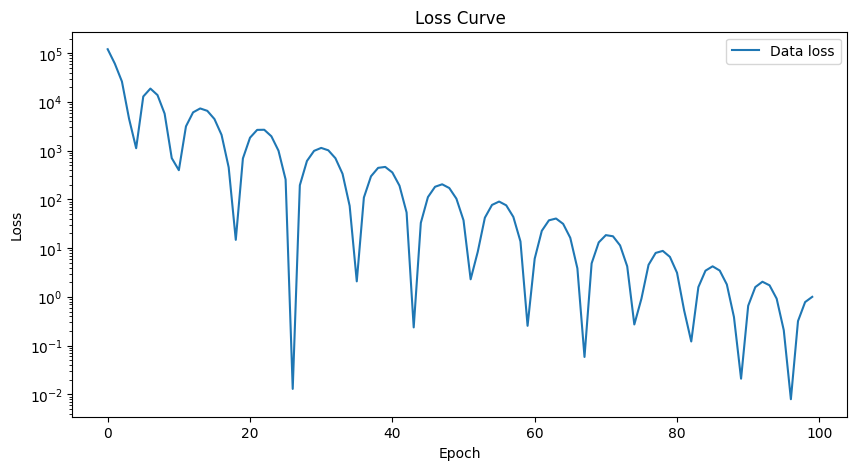

In [135]:
# Plot the loss curves
plot_loss_curves(loss_tuple=train_loss_pde_list)

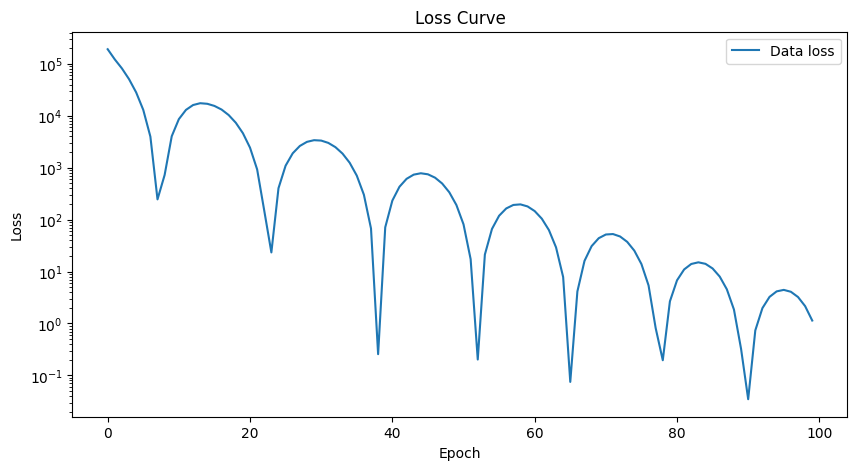

In [149]:
# Plot the loss curves
plot_loss_curves(loss_tuple=train_loss_pde_list)

In [136]:
def plot_prediction(prediction, data_y_np, title='Prediction comparison',length=1, num_nodes=100):
  """ Plot the prediction comparison.

  Args:
  - prediction (torch.Tensor): The prediction tensor.
  - data_y_np (np.array): The true data.
  - title (str): The title of the plot.
  - length (int): The length of the beam.

  """
  # Creating the plot
  fig, ax = plt.subplots(figsize=(10,5))
  beam_length = np.linspace(0, length, num_nodes)

  # Plotting the prediction curve
  ax.plot(beam_length, prediction, linestyle='-', label='Prediction')
  # Plotting true curve
  ax.plot(beam_length, data_y_np, linestyle='-', label='True')

  # Adding title and labels
  ax.set_title(title)
  ax.set_xlabel('Length')
  ax.set_ylabel('Deflection')

  # Adding a legend
  ax.legend()

  # Displaying the plot
  plt.show()

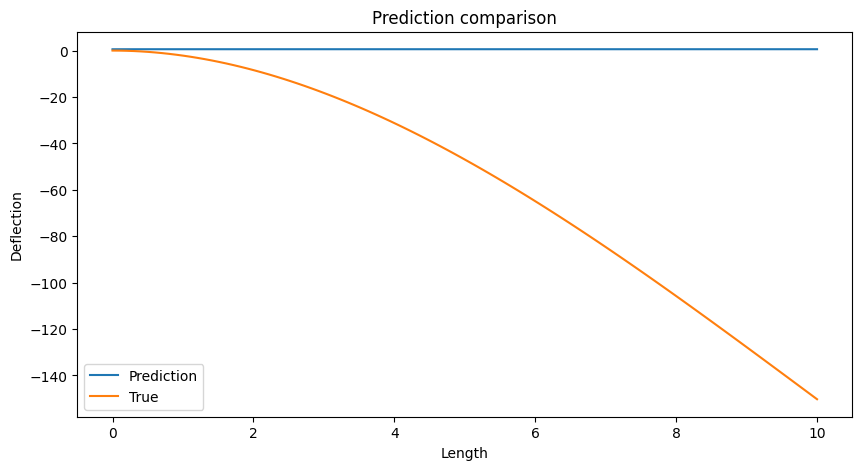

In [137]:
plot_prediction(prediction=pred_history_list[-1].cpu().detach().numpy(),
                data_y_np=data_y_np,
                title='Prediction comparison (only data loss)',
                length=10)

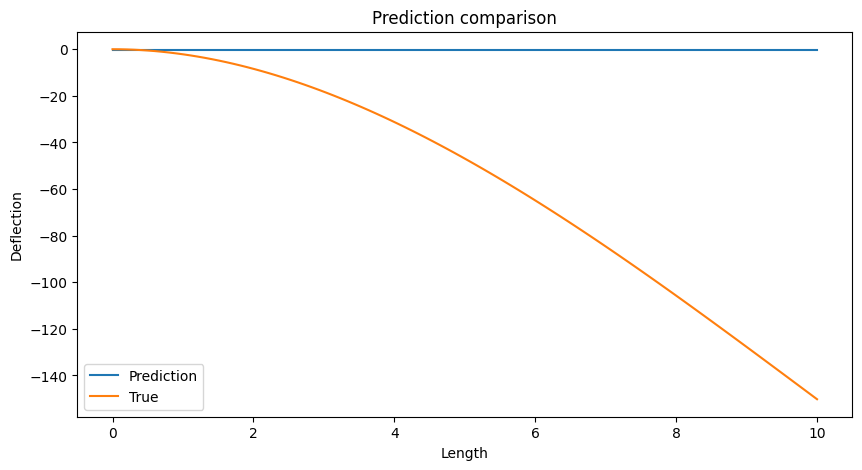

In [150]:
plot_prediction(prediction=pred_history_list[-1].cpu().detach().numpy(),
                data_y_np=data_y_np,
                title='Prediction comparison',
                length=10)

Animation code.

In [ ]:
import matplotlib.animation as animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to plot prediction for a given epoch
def plot_prediction_ani(beam_length, prediction, true_curve, epoch, ax,length,y_min, y_max):
    ax.clear()
    ax.plot(beam_length, prediction, linestyle='-', label='Prediction')
    ax.plot(beam_length, true_curve, linestyle='-', label='True')
    ax.set_title(f'Prediction comparison - Epoch {epoch + 1}')
    ax.set_xlabel('Length')
    ax.set_ylabel('Deflection')
    ax.set_xlim(0, length*1.1)
    ax.set_ylim(y_min,y_max)
    ax.legend()

# Function to create animation
def create_animation(predictions, true_curve, length=1, num_nodes=100, interval=100):
    fig, ax = plt.subplots(figsize=(10, 5))
    beam_length = np.linspace(0, length, num_nodes)
    y_min = np.min(true_curve)*1.1
    y_max = np.max(true_curve)*1.1
    def update(epoch):
      # print(predictions[epoch])
      plot_prediction_ani(beam_length, predictions[epoch], true_curve, epoch, ax,length,y_min,y_max)

    ani = animation.FuncAnimation(fig, update, frames=len(predictions), interval=interval, repeat=True)

    # Save animation as gif (uncomment to save)
    ani.save('predictions.gif', writer='imagemagick')

    plt.show()
    return ani # to be used in displaying the animation


In [ ]:
# Example data preparation
num_epochs = len(pred_history_list)  # Number of epochs based on your data
num_nodes = 100  # Adjust as needed
length = 100  # Your specific length

# Extract predictions from your history list
predictions = [pred.cpu().detach().numpy() for pred in pred_history_list]

# Example true curve (adjust based on your specific data)
true_curve = data_y_np

# Create animation
create_animation(predictions, true_curve, length, num_nodes)